## Resnet on Tiny ImageNet

在[resnet.ipynb](./resnet.ipynb)中我们测试了Resnet在Imagenette上的分类任务, Imagenette是只包含10类的ImageNet的子集,这里我们在TinyImagenet上测试对比不同的Resnet网络效果.

Tiny ImageNet 包含 100000 张图片，涵盖了200个类别（每个类别有500张图片），图片大小为64×64，并且为彩色图片。每个类别有500张训练图片，50张验证图片和50张测试图片。

随机挑选的15个类别:

![alt text](resources/tinyimagenet.png "Title")

In [ ]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)

In [2]:
from hdd.dataset.tiny_imagenet import TinyImagenet
import torchvision.transforms.v2

# 提前计算好了均值和方差
TRAIN_MEAN = [0.4802, 0.4481, 0.3975]
TRAIN_STD = [0.2302, 0.2265, 0.2262]


train_dataset_transforms = transforms.Compose(
    [
        transforms.RandomCrop(56),
        transforms.ColorJitter(0.1),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
train_dataset = TinyImagenet(
    root=DATA_ROOT, split="train", download=True, transform=train_dataset_transforms
)
val_dataset = TinyImagenet(
    root=DATA_ROOT,
    split="val",
    download=True,
    transform=transforms.Compose(
        [
            transforms.CenterCrop(56),
            transforms.ToTensor(),
            transforms.Normalize(TRAIN_MEAN, TRAIN_STD),
        ]
    ),
)
print("Basic Info of train dataaset: \n", train_dataset)
print("Basic Info of test dataset: \n", val_dataset)

Basic Info of train dataaset: 
 Dataset TinyImagenet
    Number of datapoints: 100000
    Root location: /home/tf/workspace/hands-dirty-on-dl/dataset
    StandardTransform
Transform: Compose(
               RandomCrop(size=(56, 56), padding=None)
               ColorJitter(brightness=(0.9, 1.1), contrast=None, saturation=None, hue=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2302, 0.2265, 0.2262])
           )
Basic Info of test dataset: 
 Dataset TinyImagenet
    Number of datapoints: 10000
    Root location: /home/tf/workspace/hands-dirty-on-dl/dataset
    StandardTransform
Transform: Compose(
               CenterCrop(size=(56, 56))
               ToTensor()
               Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2302, 0.2265, 0.2262])
           )


In [3]:
BATCH_SIZE = 64
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

## 测试比较不同的Resnet架构

In [4]:
from spacy import training
from hdd.models.cnn.resnet import ResnetSmall, resnet18_config
from hdd.train.early_stopping import EarlyStoppingInMem
from hdd.train.classification_utils import (
    naive_train_classification_model,
    eval_image_classifier,
)
from hdd.models.nn_utils import count_trainable_parameter


def train_net(
    resnet_config,
    train_dataloader,
    val_dataloader,
    dropout,
    lr,
    weight_decay,
    step_size=30,
    gamma=0.1,
    patience=40,
    max_epochs=120,
) -> tuple[ResnetSmall, dict[str, list[float]]]:
    net = ResnetSmall(resnet_config, num_classes=200, dropout=dropout).to(DEVICE)
    criteria = nn.CrossEntropyLoss()
    # SGD的收敛速度远不如Adam好
    # optimizer = torch.optim.SGD(
    #     net.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay
    # )
    optimizer = optim.AdamW(
        net.parameters(), lr=lr, eps=1e-6, weight_decay=weight_decay
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=step_size, gamma=gamma, last_epoch=-1
    )
    early_stopper = EarlyStoppingInMem(patience=patience, verbose=False)
    training_stats = naive_train_classification_model(
        net,
        criteria,
        max_epochs,
        train_dataloader,
        val_dataloader,
        DEVICE,
        optimizer,
        scheduler,
        early_stopper,
        verbose=True,
    )
    return net, training_stats


net, resnet18_stats = train_net(
    resnet18_config,
    train_dataloader,
    val_dataloader,
    dropout=0.5,
    lr=0.005,
    weight_decay=1e-2,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

Epoch: 1/120 Train Loss: 4.6324 Accuracy: 0.0568 Time: 45.97297  | Val Loss: 3.9824 Accuracy: 0.1311
Epoch: 2/120 Train Loss: 3.9277 Accuracy: 0.1399 Time: 46.46360  | Val Loss: 3.5897 Accuracy: 0.2042
Epoch: 3/120 Train Loss: 3.5212 Accuracy: 0.2047 Time: 45.35173  | Val Loss: 3.2178 Accuracy: 0.2570
Epoch: 4/120 Train Loss: 3.2334 Accuracy: 0.2559 Time: 46.36122  | Val Loss: 2.9562 Accuracy: 0.3060
Epoch: 5/120 Train Loss: 3.0049 Accuracy: 0.2987 Time: 46.55920  | Val Loss: 2.7445 Accuracy: 0.3492
Epoch: 6/120 Train Loss: 2.8266 Accuracy: 0.3340 Time: 45.84230  | Val Loss: 2.6069 Accuracy: 0.3814
Epoch: 7/120 Train Loss: 2.6716 Accuracy: 0.3661 Time: 45.88423  | Val Loss: 2.4709 Accuracy: 0.4105
Epoch: 8/120 Train Loss: 2.5467 Accuracy: 0.3903 Time: 46.02452  | Val Loss: 2.3870 Accuracy: 0.4286
Epoch: 9/120 Train Loss: 2.4274 Accuracy: 0.4147 Time: 46.04501  | Val Loss: 2.2947 Accuracy: 0.4465
Epoch: 10/120 Train Loss: 2.3308 Accuracy: 0.4357 Time: 46.02318  | Val Loss: 2.2962 Accura

In [7]:
from hdd.models.cnn.resnet import resnet34_config

net, resnet34_stats = train_net(
    resnet34_config,
    train_dataloader,
    val_dataloader,
    dropout=0.5,
    lr=0.005,
    weight_decay=5e-2,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

Epoch: 1/120 Train Loss: 4.6180 Accuracy: 0.0607 Time: 77.13795  | Val Loss: 3.9977 Accuracy: 0.1227
Epoch: 2/120 Train Loss: 3.8806 Accuracy: 0.1470 Time: 76.83033  | Val Loss: 3.4955 Accuracy: 0.2134
Epoch: 3/120 Train Loss: 3.5015 Accuracy: 0.2071 Time: 76.59613  | Val Loss: 3.2148 Accuracy: 0.2597
Epoch: 4/120 Train Loss: 3.2591 Accuracy: 0.2523 Time: 77.45329  | Val Loss: 2.9946 Accuracy: 0.2992
Epoch: 5/120 Train Loss: 3.0870 Accuracy: 0.2840 Time: 75.94696  | Val Loss: 2.9374 Accuracy: 0.3089
Epoch: 6/120 Train Loss: 2.9577 Accuracy: 0.3093 Time: 76.10020  | Val Loss: 2.8393 Accuracy: 0.3317
Epoch: 7/120 Train Loss: 2.8604 Accuracy: 0.3286 Time: 76.09025  | Val Loss: 2.8564 Accuracy: 0.3281
Epoch: 8/120 Train Loss: 2.7813 Accuracy: 0.3437 Time: 76.08648  | Val Loss: 2.7285 Accuracy: 0.3567
Epoch: 9/120 Train Loss: 2.7275 Accuracy: 0.3563 Time: 76.07937  | Val Loss: 2.6968 Accuracy: 0.3588
Epoch: 10/120 Train Loss: 2.6802 Accuracy: 0.3662 Time: 76.08067  | Val Loss: 2.8512 Accura

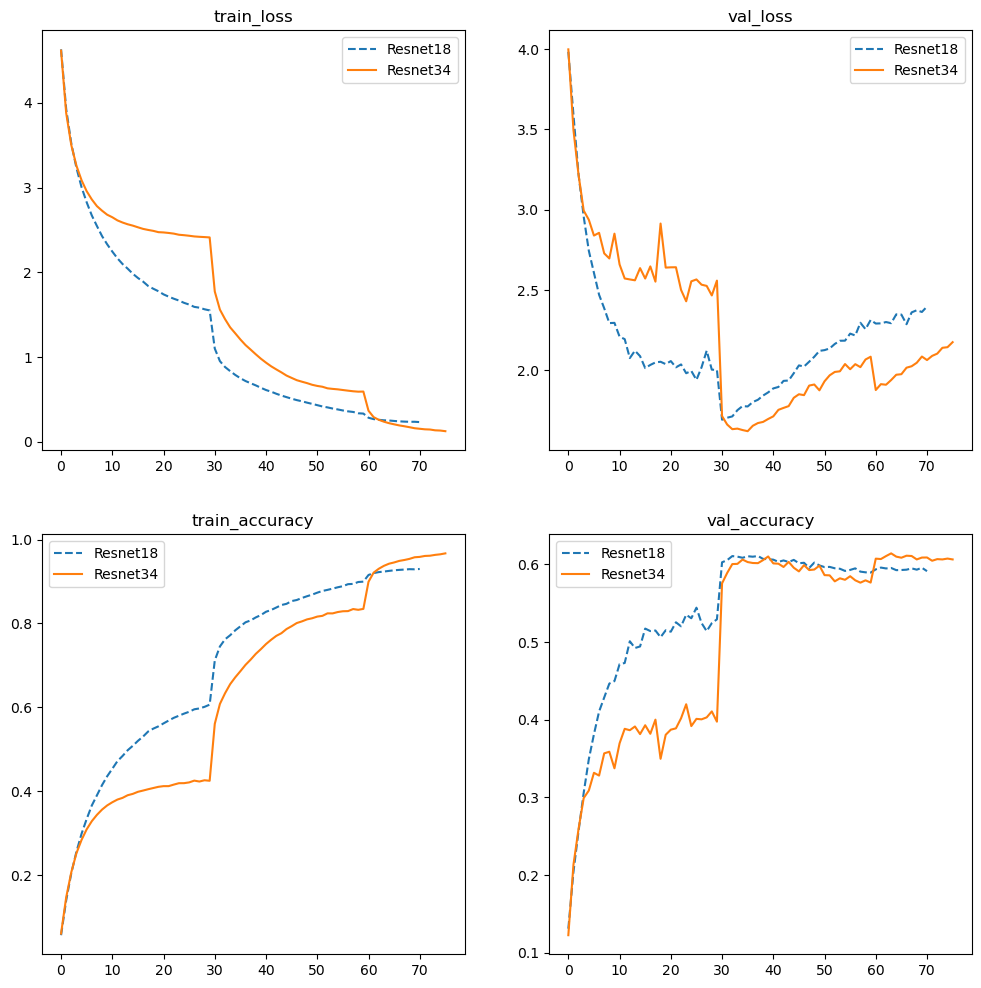

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = resnet18_stats.keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(resnet18_stats[field], label="Resnet18", linestyle="--")
    plt.plot(resnet34_stats[field], label="Resnet34")
    plt.legend()
    plt.title(field)

In [10]:
## Plot train dataset.
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(16,5))
# images_per_class = 5
# num_classes = 15

# for target_class in range(num_classes):
#     idxs = [idx  for idx, target  in enumerate(train_dataset.targets) if target == target_class]
#     idxs = idxs[:images_per_class]
#     for i, idx in enumerate(idxs):
#         plt_idx = i * num_classes + target_class + 1
#         plt.subplot(images_per_class, num_classes, plt_idx)
#         image,_ = train_dataset[idx]
#         plt.imshow(image)
#         plt.axis("off")
#         if i == 0:
#             plt.title(f"{train_dataset.classes[target_class][0]}", fontsize = "x-small")
# plt.show()